# 90 Days Rate of Change Trading Strategy

This notebook documents a 90-day trading experiment using the Rate of Change (ROC) indicator.

The objective is to observe how ROC behaves over a short, fixed trading window:
- How often does it generate signals?
- How does the equity curve evolve?
- How does it compare to buy-and-hold over the same period?

This is an observational experiment, not an optimised strategy.

In [14]:
%pip install yfinance matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.grid"] = True

## Data Selection

We download historical price data and restrict the analysis to the most recent
90 trading days.

In [16]:
symbol = "SPY"
lookback_days = 90

df = yf.download(symbol, period="6mo")  # buffer for ROC calculation
df = df[["Close"]].dropna()

df = df.tail(lookback_days)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,SPY
Date,
2025-10-02,667.248291
2025-10-03,667.238403
2025-10-06,669.631287
2025-10-07,667.148621
2025-10-08,671.126892


## Price Action Over 90 Days

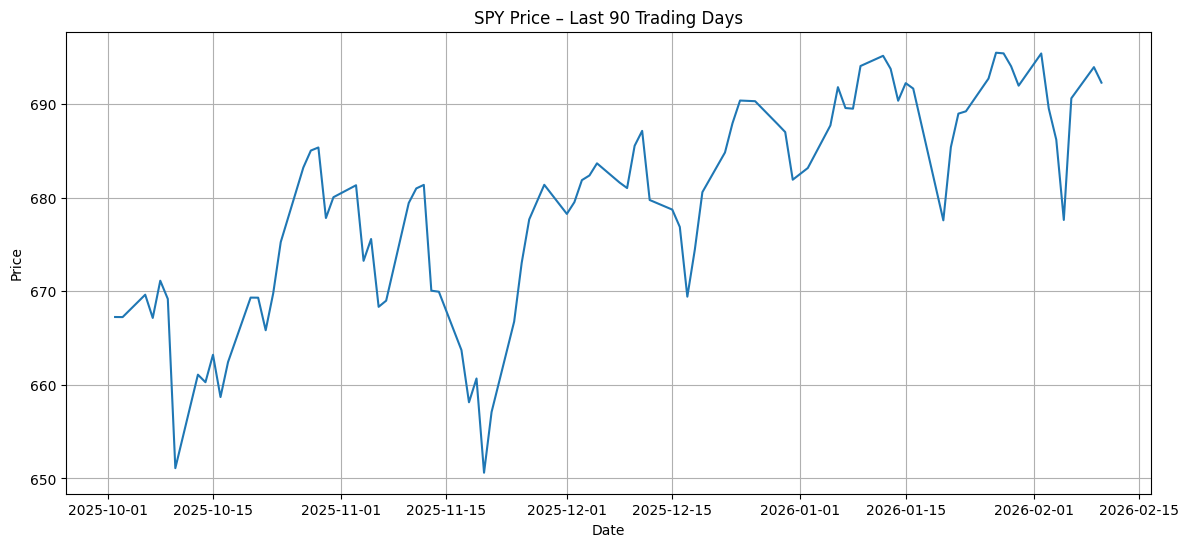

In [17]:
plt.plot(df.index, df["Close"])
plt.title(f"{symbol} Price – Last 90 Trading Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.savefig("price_chart.png")
plt.show()

## Rate of Change Indicator

Rate of Change measures the percentage price change over a fixed period.

In [18]:
roc_period = 10  # short-term momentum

df["ROC"] = df["Close"].pct_change(roc_period)
df.dropna(inplace=True)
df.head()

Price,Close,ROC
Ticker,SPY,
Date,,
2025-10-16,658.693665,-0.012821
2025-10-17,662.432617,-0.007203
2025-10-20,669.322205,-0.000462
2025-10-21,669.312195,0.003243
2025-10-22,665.832520,-0.007889


## ROC Behaviour During the Experiment

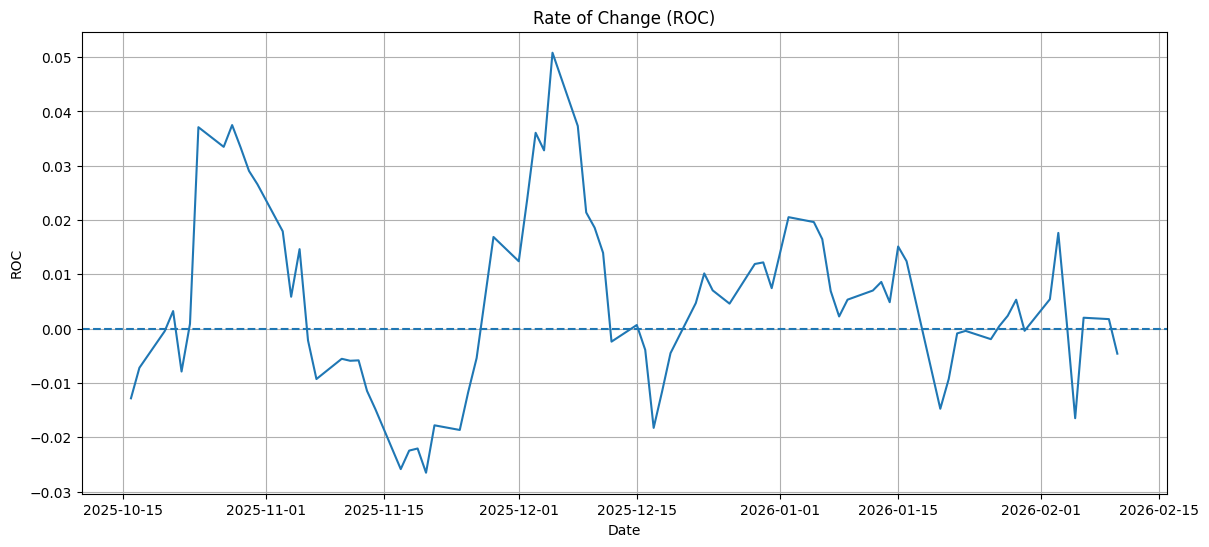

In [19]:
plt.plot(df.index, df["ROC"])
plt.axhline(0, linestyle="--")
plt.title("Rate of Change (ROC)")
plt.xlabel("Date")
plt.ylabel("ROC")
plt.savefig("roc_chart.png")
plt.show()

## Trading Rules Used in the Experiment

- Enter long when ROC crosses above zero
- Exit when ROC crosses below zero
- One position at a time
- No leverage
- No transaction costs

The goal is to isolate the effect of ROC itself.

In [20]:
df["Signal"] = 0
df.loc[df["ROC"] > 0, "Signal"] = 1
df["Signal"] = df["Signal"].shift(1)
df.dropna(inplace=True)

## Returns Calculation

In [21]:
df["Market_Return"] = df["Close"].pct_change()
df["Strategy_Return"] = df["Signal"] * df["Market_Return"]

df.dropna(inplace=True)

## Equity Curve: Strategy vs Buy-and-Hold

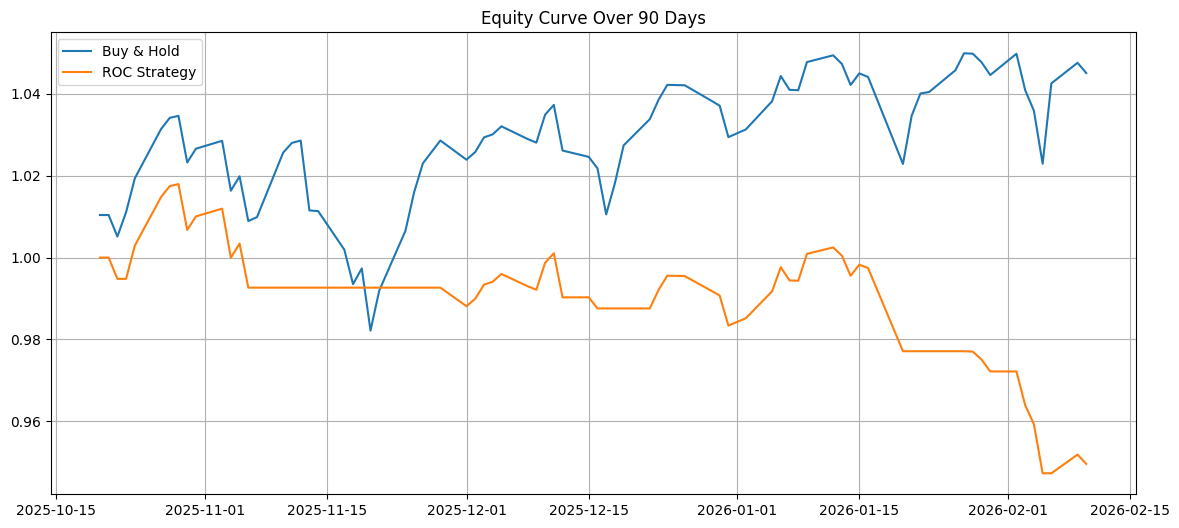

In [22]:
df["Market_Equity"] = (1 + df["Market_Return"]).cumprod()
df["Strategy_Equity"] = (1 + df["Strategy_Return"]).cumprod()

plt.plot(df.index, df["Market_Equity"], label="Buy & Hold")
plt.plot(df.index, df["Strategy_Equity"], label="ROC Strategy")
plt.title("Equity Curve Over 90 Days")
plt.legend()
plt.savefig("equity_curve.png")
plt.show()

## Performance Metrics

In [23]:
trades = df["Signal"].diff().abs().sum()

total_return_strategy = df["Strategy_Equity"].iloc[-1] - 1
total_return_market = df["Market_Equity"].iloc[-1] - 1

max_dd = (df["Strategy_Equity"] / df["Strategy_Equity"].cummax() - 1).min()

pd.DataFrame({
    "Metric": [
        "Number of Trades",
        "Strategy Total Return",
        "Buy & Hold Total Return",
        "Max Drawdown"
    ],
    "Value": [
        trades,
        f"{total_return_strategy:.2%}",
        f"{total_return_market:.2%}",
        f"{max_dd:.2%}"
    ]
})

,Metric,Value
0,Number of Trades,15.0
1,Strategy Total Return,-5.04%
2,Buy & Hold Total Return,4.51%
3,Max Drawdown,-6.94%


## Strategy Drawdowns

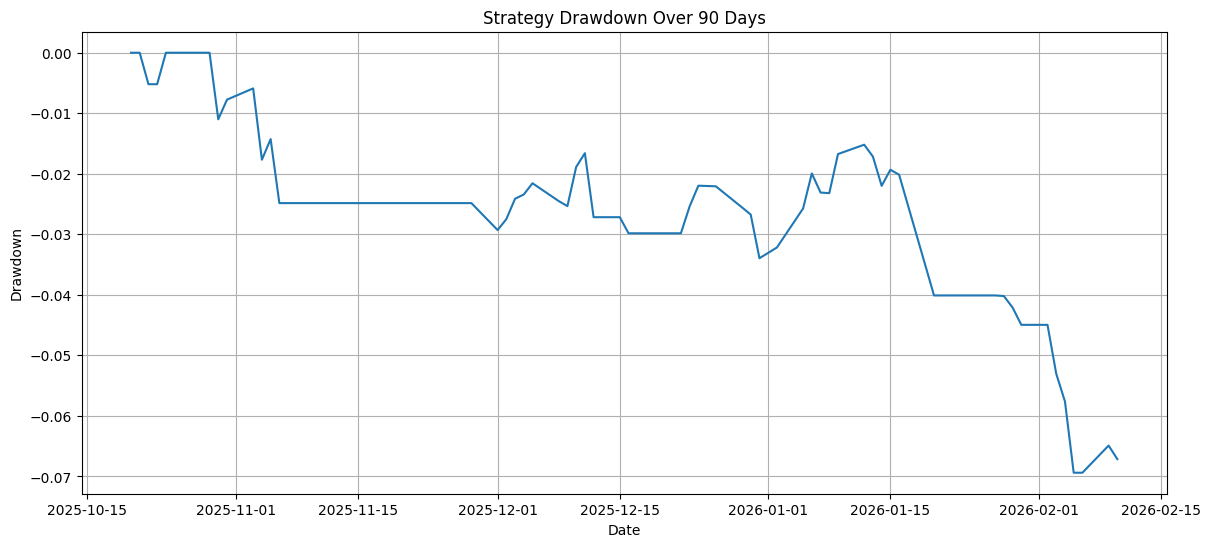

In [24]:
drawdown = df["Strategy_Equity"] / df["Strategy_Equity"].cummax() - 1

plt.plot(df.index, drawdown)
plt.title("Strategy Drawdown Over 90 Days")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.savefig("drawdown_chart.png")
plt.show()